In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import pdist, squareform
#from skbio.stats.distance import mantel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

from sklearn.impute import SimpleImputer 

In [6]:
# File paths
csv12 = '/Users/schoudhry/Desktop/IIT/Research/researchData/StableS12.csv'
csv13 = '/Users/schoudhry/Desktop/IIT/Research/researchData/Stable13.csv'
csv6 = '/Users/schoudhry/Desktop/IIT/Research/researchData/Supplementary Tables S6 S6.csv'
csv1 = '/Users/schoudhry/Desktop/IIT/Research/researchData/Stable1.csv'

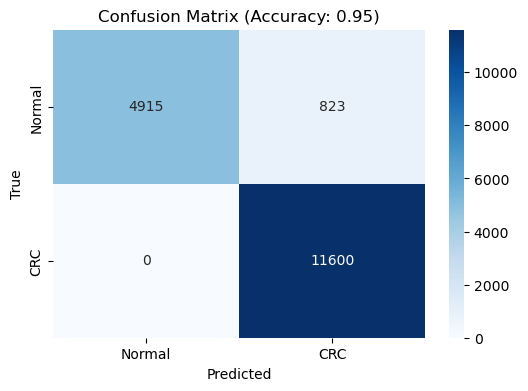

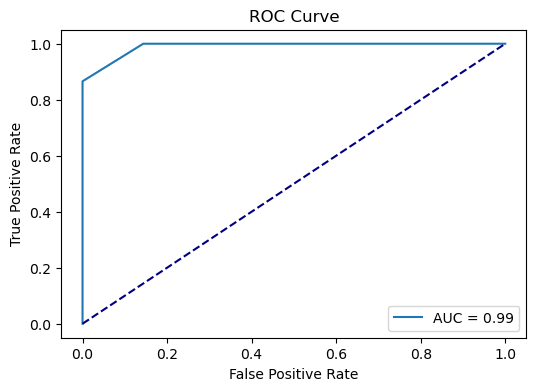

(0.9525320106125273, 0.9903741316210142)

In [7]:
# Required Libraries
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the provided paths
csv12_path = '/Users/schoudhry/Desktop/IIT/Research/researchData/StableS12.csv'
csv13_path = '/Users/schoudhry/Desktop/IIT/Research/researchData/Stable13.csv'
csv6_path = '/Users/schoudhry/Desktop/IIT/Research/researchData/Supplementary Tables S6 S6.csv'
csv1_path = '/Users/schoudhry/Desktop/IIT/Research/researchData/Stable1.csv'

df_genes = pd.read_csv(csv12_path)  # Gene expression data (S12)
df_bacteria = pd.read_csv(csv13_path)  # Bacterial abundance data (S13)
df_stable1 = pd.read_csv(csv1_path)  # CRC Status from Stable1
df_associations = pd.read_csv(csv6_path, header=1)  # Gene-bacteria associations (S6)

# Step 1: Extract gene expression for B01, B02, B03 from S12
df_genes_subset = df_genes[['Unnamed: 0', 'B01', 'B02', 'B03']].copy()
df_genes_subset.columns = ['Gene', 'B01_Expression', 'B02_Expression', 'B03_Expression']

# Step 2: Extract bacterial abundance for B01, B02, B03 from S13
df_bacteria_subset = df_bacteria[['Unnamed: 0', 'B01', 'B02', 'B03']].copy()
df_bacteria_subset.columns = ['Bacteria', 'B01_Abundance', 'B02_Abundance', 'B03_Abundance']

# Step 3: Merge gene expression and bacterial abundance for B01, B02, B03
df_merged_b01 = pd.concat([df_genes_subset[['B01_Expression']], df_bacteria_subset[['B01_Abundance']]], axis=1)
df_merged_b02 = pd.concat([df_genes_subset[['B02_Expression']], df_bacteria_subset[['B02_Abundance']]], axis=1)
df_merged_b03 = pd.concat([df_genes_subset[['B03_Expression']], df_bacteria_subset[['B03_Abundance']]], axis=1)

# Step 4: Add CRC labels for B01, B02, B03 from Stable1
df_stable1['CRC_Status'] = df_stable1['Description'].apply(lambda x: 1 if x == 'tumor' else 0)
crc_status_b01 = df_stable1[df_stable1['Tissue.RNA.DNA_Tube_ID'] == 'B01']['CRC_Status'].values[0]
crc_status_b02 = df_stable1[df_stable1['Tissue.RNA.DNA_Tube_ID'] == 'B02']['CRC_Status'].values[0]
crc_status_b03 = df_stable1[df_stable1['Tissue.RNA.DNA_Tube_ID'] == 'B03']['CRC_Status'].values[0]

# Combine the merged data for all patients into one dataframe
df_combined = pd.concat([df_merged_b01, df_merged_b02, df_merged_b03], axis=0)
df_combined['CRC_Status'] = [crc_status_b01] * len(df_merged_b01) + [crc_status_b02] * len(df_merged_b02) + [crc_status_b03] * len(df_merged_b03)

# Step 5: Handle missing values by filling NaNs with 0
df_combined.fillna(0, inplace=True)

# Step 6: Prepare X (features) and y (target)
X = df_combined.drop(columns=['CRC_Status']).values  # Gene expression and bacterial abundance as features
y = df_combined['CRC_Status'].values  # CRC status as target

# Step 7: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 8: Build and train a Logistic Regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Step 9: Make predictions
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

# Step 10: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'CRC'], yticklabels=['Normal', 'CRC'])
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2f})')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.show()

# Print the accuracy and AUC for further reference
accuracy, roc_auc


Correlation Matrix:
             Actual  Predicted
Actual     1.000000   0.894329
Predicted  0.894329   1.000000

R-squared Value: 0.785621957668778


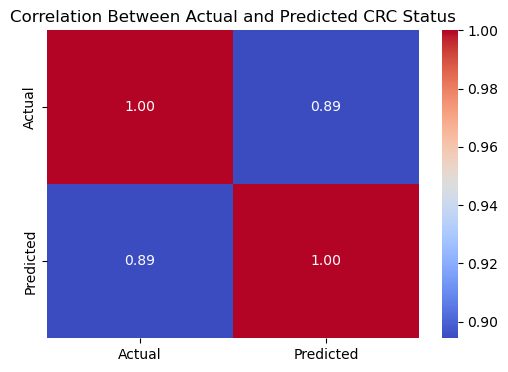

In [9]:
# Step 1: Compute the R-squared value
r_squared = r2_score(y_test, y_pred)

# Step 2: Compare predictions against actual results with a correlation matrix
df_comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Correlation between actual and predicted values
correlation_matrix = df_comparison.corr()

# Step 3: Display the correlation matrix and R-squared value
print("Correlation Matrix:")
print(correlation_matrix)

print(f"\nR-squared Value: {r_squared}")

# Visualize the correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Actual and Predicted CRC Status')
plt.show()
